In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns

In [13]:
proposicao_microdados = pd.read_csv('..\data\dados abertos\proposicao_microdados.csv');
proposicao_tema = pd.read_csv('..\data\dados abertos\proposicao_tema.csv');
votacao_objeto = pd.read_csv('..\data\dados abertos/votacao_objeto.csv');
votacao_parlamentar = pd.read_csv('..\data\dados abertos/votacao_parlamentar.csv');
votacao = pd.read_csv('..\data\dados abertos/votacao.csv');

e:\Anaconda\envs\camara-analysis_3\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
# Renomeando as colunas de proposicao_microdados e votacao_objeto
proposicao_microdados.rename(columns={'data': 'data_proposicao', 'ano': 'ano_proposicao'}, inplace=True)
votacao_objeto.rename(columns={'data': 'data_votacao'}, inplace=True)

# Juntando as tabelas com base nas chaves fornecidas
analise_votacao = proposicao_microdados[['id_proposicao', 'ano_proposicao', 'data_proposicao', 'sigla', 'tipo']]
analise_votacao = analise_votacao.merge(proposicao_tema[['id_proposicao', 'tema']], on='id_proposicao', how='left')
analise_votacao = analise_votacao.merge(votacao_objeto[['id_proposicao', 'id_votacao', 'data_votacao']], on='id_proposicao', how='left')
analise_votacao = analise_votacao.merge(votacao[['id_votacao', 'sigla_orgao', 'aprovacao', 'voto_sim', 'voto_nao', 'voto_outro']], on='id_votacao', how='left')

In [15]:
# Converter a coluna 'data_votacao' para o formato datetime
analise_votacao['data_votacao'] = pd.to_datetime(analise_votacao['data_votacao'], errors='coerce')

# Criar a nova coluna 'ano_votacao' extraindo o ano da coluna 'data_votacao'
analise_votacao['ano_votacao'] = analise_votacao['data_votacao'].dt.year

# Removendo valores nulos e convertendo a coluna 'ano_votacao' para int
analise_votacao['ano_votacao'] = analise_votacao['ano_votacao'].fillna(0).astype(int)

# Calculando o total de votos
analise_votacao['total_votos'] = analise_votacao['voto_sim'] + analise_votacao['voto_nao'] + analise_votacao['voto_outro']

# Filtrando apenas as votações com mais de 200 votos
analise_votacao = analise_votacao[analise_votacao['total_votos'] > 200]

# Filtrando apenas as votações onde sigla_orgao é igual a 'PLEN' ou 'PLENARIO'
analise_votacao = analise_votacao[analise_votacao['sigla_orgao'].isin(['PLEN', 'PLENARIO'])]

# Função para substituir os valores NaN com base na comparação entre 'voto_sim' e 'voto_nao'
def avaliar_aprovacao(row):
    if pd.isna(row['aprovacao']):  # Se 'aprovacao' for NaN
        if row['voto_nao'] > row['voto_sim']:
            return 0  # Rejeitada
        else:
            return 1  # Aprovada
    else:
        return row['aprovacao']  # Manter o valor existente se não for NaN

# Aplicar a função para substituir os valores NaN na coluna 'aprovacao'
analise_votacao['aprovacao'] = analise_votacao.apply(avaliar_aprovacao, axis=1)

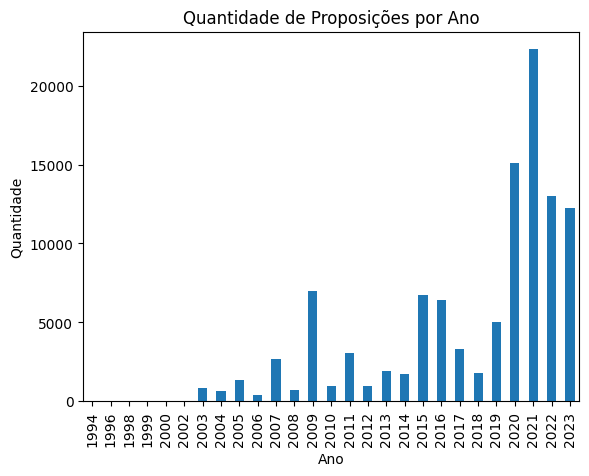

In [16]:
analise_votacao.groupby('ano_proposicao').size().plot(kind='bar', title='Quantidade de Proposições por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.show()

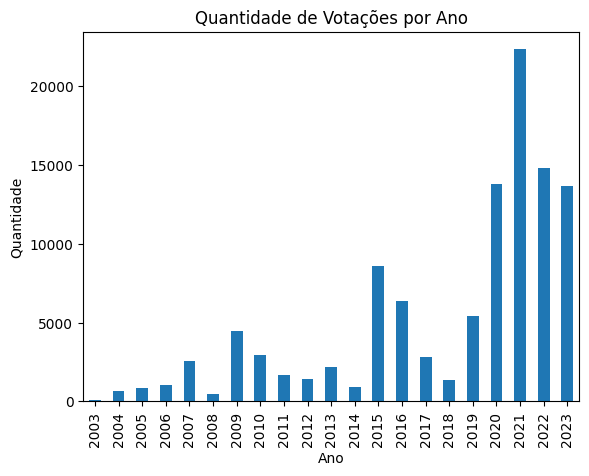

In [17]:
analise_votacao.groupby(analise_votacao['ano_votacao']).size().plot(kind='bar', title='Quantidade de Votações por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade')
plt.show()

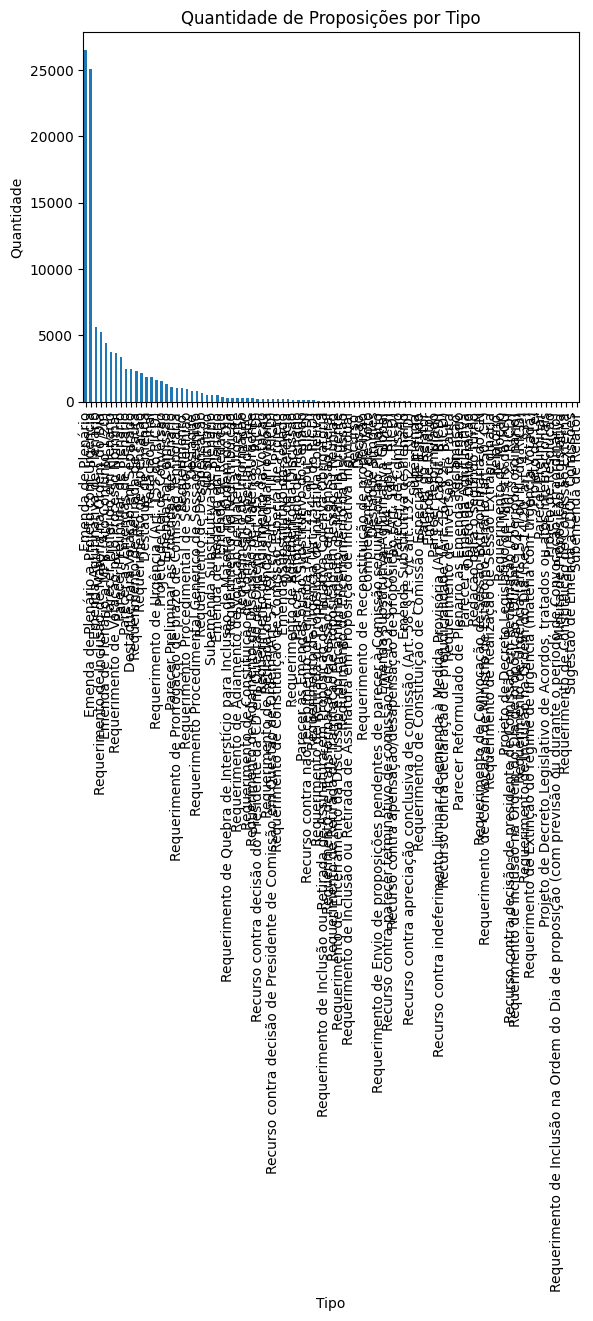

In [18]:
analise_votacao['tipo'].value_counts().plot(kind='bar', title='Quantidade de Proposições por Tipo')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.show()

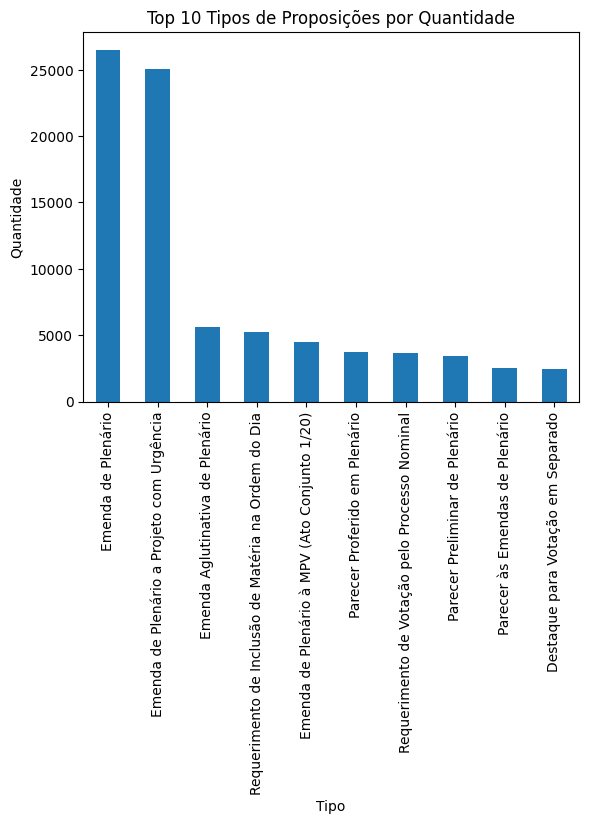

In [19]:
# Filtrando os 10 tipos mais frequentes
top_10_tipos = analise_votacao['tipo'].value_counts().nlargest(10)

# Plotando o gráfico apenas com os top 10
top_10_tipos.plot(kind='bar', title='Top 10 Tipos de Proposições por Quantidade')
plt.xlabel('Tipo')
plt.ylabel('Quantidade')
plt.show()

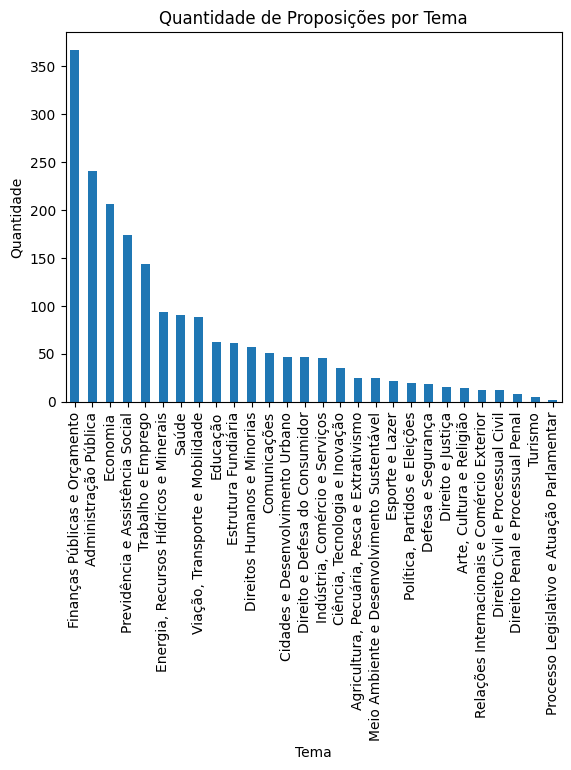

In [20]:
analise_votacao['tema'].value_counts().plot(kind='bar', title='Quantidade de Proposições por Tema')
plt.xlabel('Tema')
plt.ylabel('Quantidade')
plt.show()

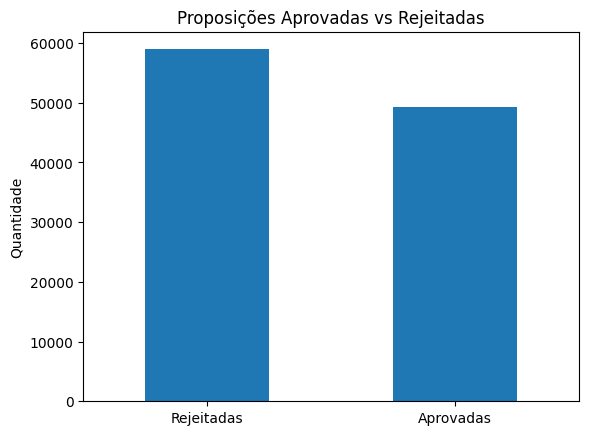

In [21]:
# Mapeando os valores 0 e 1 para "Rejeitadas" e "Aprovadas"
mapeamento = {0: 'Rejeitadas', 1: 'Aprovadas'}

# Plotando o gráfico com os novos rótulos e ajustes no eixo X
ax = analise_votacao['aprovacao'].map(mapeamento).value_counts().plot(kind='bar', title='Proposições Aprovadas vs Rejeitadas')
plt.xlabel('')  # Remove o rótulo do eixo X
plt.ylabel('Quantidade')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)  # Deixa os textos na horizontal
plt.show()

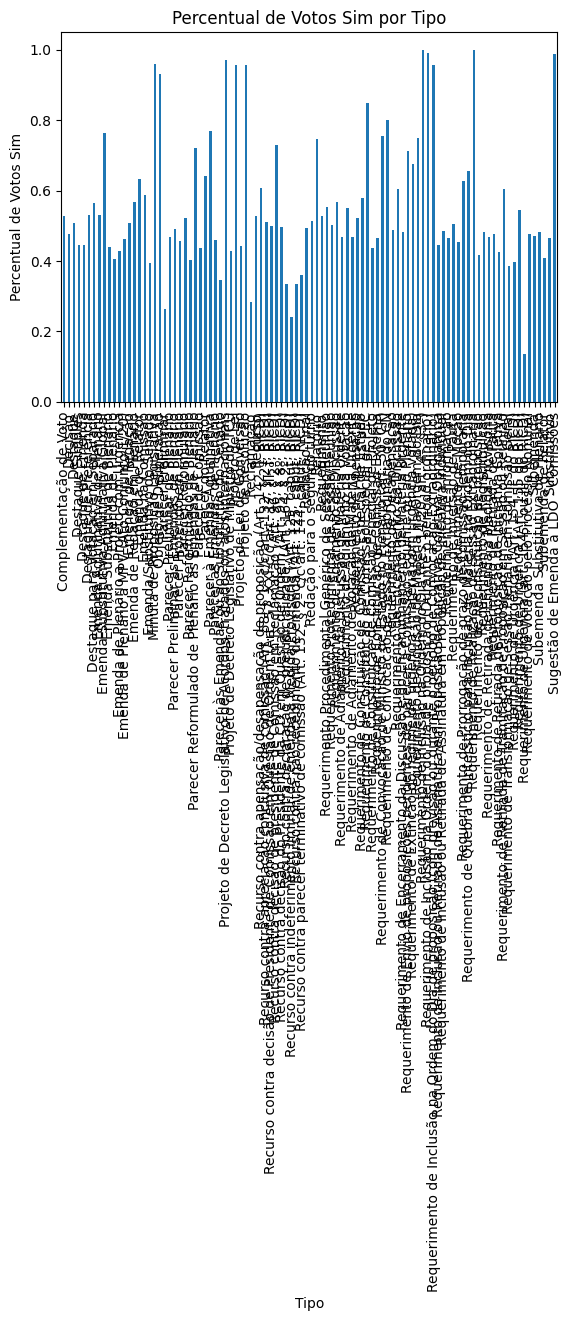

In [22]:
votos_totais = analise_votacao['voto_sim'] + analise_votacao['voto_nao'] + analise_votacao['voto_outro']
analise_votacao['percentual_voto_sim'] = analise_votacao['voto_sim'] / votos_totais

analise_votacao.groupby('tipo')['percentual_voto_sim'].mean().plot(kind='bar', title='Percentual de Votos Sim por Tipo')
plt.xlabel('Tipo')
plt.ylabel('Percentual de Votos Sim')
plt.show()

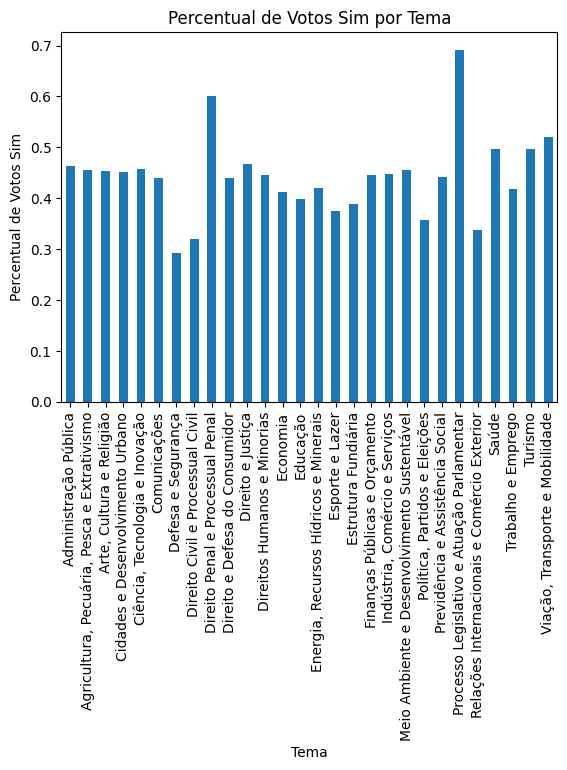

In [23]:
analise_votacao.groupby('tema')['percentual_voto_sim'].mean().plot(kind='bar', title='Percentual de Votos Sim por Tema')
plt.xlabel('Tema')
plt.ylabel('Percentual de Votos Sim')
plt.show()

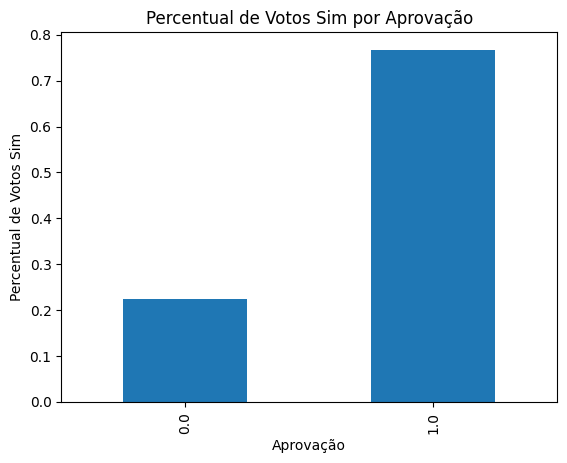

In [40]:
analise_votacao.groupby('aprovacao')['percentual_voto_sim'].mean().plot(kind='bar', title='Percentual de Votos Sim por Aprovação')
plt.xlabel('Aprovação')
plt.ylabel('Percentual de Votos Sim')
plt.show()

In [25]:
# Criando uma nova coluna para os intervalos de percentual de votos sim
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-10%', '11-20%', '21-30%', '31-40%', '41-50%', '51-60%', '61-70%', '71-80%', '81-90%', '91-100%']
analise_votacao['percentual_voto_sim_intervalo'] = pd.cut(analise_votacao['percentual_voto_sim']*100, bins=bins, labels=labels, include_lowest=True)

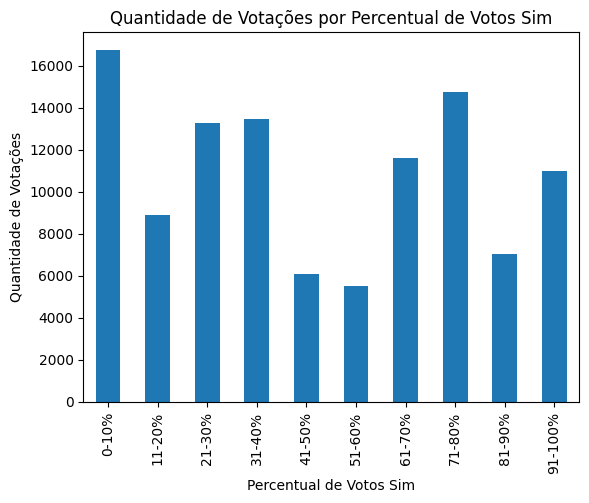

In [26]:
# Contar o número de votações em cada intervalo
analise_votacao['percentual_voto_sim_intervalo'].value_counts(sort=False).plot(kind='bar', title='Quantidade de Votações por Percentual de Votos Sim')
plt.xlabel('Percentual de Votos Sim')
plt.ylabel('Quantidade de Votações')
plt.show()

In [27]:
# Calculando o desvio padrão dos percentuais de votos "sim"
desvio_padrao_votos_sim = analise_votacao['percentual_voto_sim'].std()

print(f"Desvio Padrão dos Percentuais de Votos Sim: {desvio_padrao_votos_sim:.2f}")

Desvio Padrão dos Percentuais de Votos Sim: 0.31


In [28]:
# Calculando a proporção de votações com polarização extrema (muito próxima de 0% ou 100%)
votacoes_extremas = analise_votacao[(analise_votacao['percentual_voto_sim'] <= 0.3) | (analise_votacao['percentual_voto_sim'] >= 0.7)]
indice_polarizacao = len(votacoes_extremas) / len(analise_votacao)

print(f"Índice de Polarização (Proporção de votações nos extremos): {indice_polarizacao:.2%}")

Índice de Polarização (Proporção de votações nos extremos): 66.25%


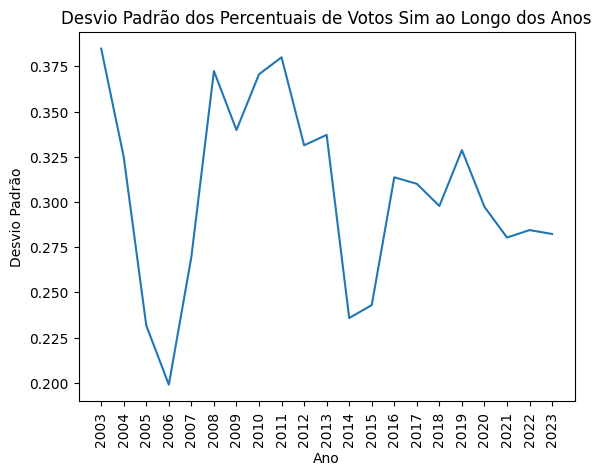

In [29]:
# Agrupar por ano e calcular o desvio padrão dos percentuais de votos "sim"
desvio_padrao_anos = analise_votacao.groupby('ano_votacao')['percentual_voto_sim'].std()

# Plotar o desvio padrão ao longo dos anos com ajuste de rótulos do eixo x
desvio_padrao_anos.plot(kind='line', title='Desvio Padrão dos Percentuais de Votos Sim ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Desvio Padrão')

# Ajustar os ticks do eixo x para inteiros e rotação vertical
plt.xticks(ticks=desvio_padrao_anos.index, labels=desvio_padrao_anos.index.astype(int), rotation=90)
plt.show()

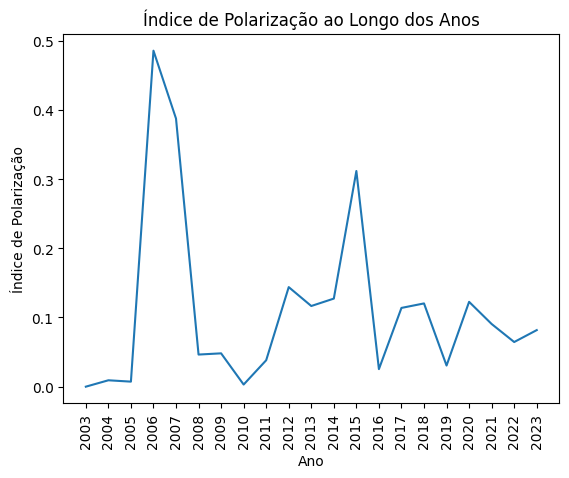

In [30]:
# Definindo uma função para calcular o índice de polarização
def calcular_indice_polarizacao(grupo):
    votacoes_polarizadas = grupo[(grupo['percentual_voto_sim'] >= 0.4) & (grupo['percentual_voto_sim'] <= 0.6)]
    
    return len(votacoes_polarizadas) / len(grupo)

# Aplicando a função para cada ano
indice_polarizacao_anos = analise_votacao.groupby('ano_votacao').apply(calcular_indice_polarizacao)

# Plotar o índice de polarização ao longo dos anos com ajuste de rótulos do eixo x
indice_polarizacao_anos.plot(kind='line', title='Índice de Polarização ao Longo dos Anos')
plt.xlabel('Ano')
plt.ylabel('Índice de Polarização')

# Ajustar os ticks do eixo x para inteiros e rotação vertical
plt.xticks(ticks=indice_polarizacao_anos.index, labels=indice_polarizacao_anos.index.astype(int), rotation=90)
plt.show()

C:\Users\Pedro Natanael\AppData\Local\Temp\ipykernel_19488\3774919476.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados_filtrados['percentual_voto_sim_intervalo'] = pd.cut(dados_filtrados['percentual_voto_sim']*100, bins=bins, labels=labels, include_lowest=True)


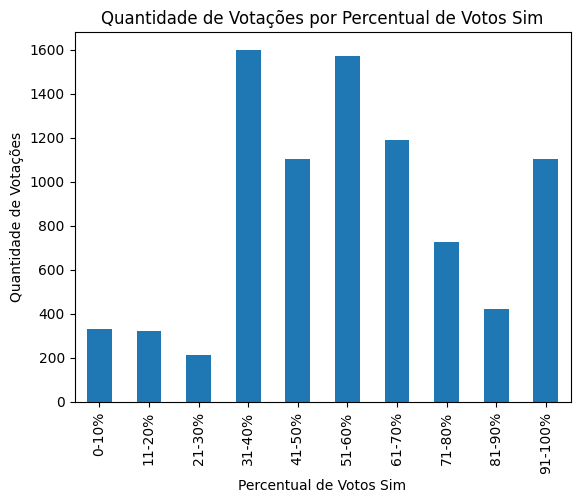

In [31]:
ano = 2015
dados_filtrados = analise_votacao[analise_votacao['ano_votacao'] == ano]

# Criar os intervalos de percentuais de votos sim para o ano filtrado
dados_filtrados['percentual_voto_sim_intervalo'] = pd.cut(dados_filtrados['percentual_voto_sim']*100, bins=bins, labels=labels, include_lowest=True)

# Contar o número de votações em cada intervalo e plotar
dados_filtrados['percentual_voto_sim_intervalo'].value_counts(sort=False).plot(kind='bar', title='Quantidade de Votações por Percentual de Votos Sim')
plt.xlabel('Percentual de Votos Sim')
plt.ylabel('Quantidade de Votações')
plt.show()

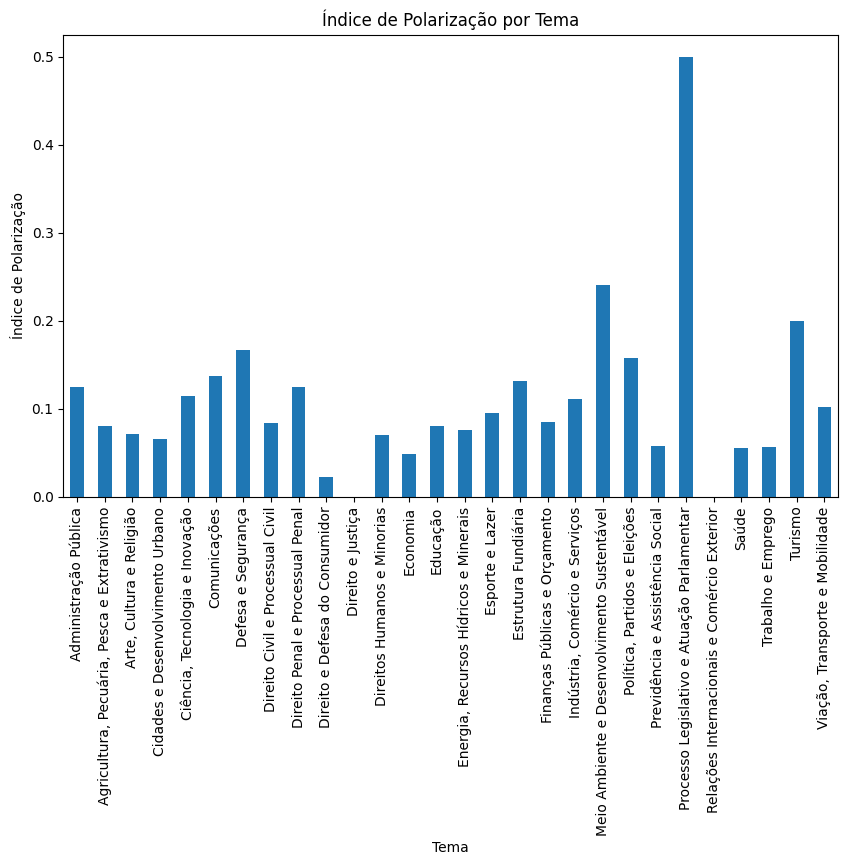

In [32]:
# Aplicando a função para cada tema
indice_polarizacao_tema = analise_votacao.groupby('tema').apply(calcular_indice_polarizacao)

# Plotando o índice de polarização por tema
indice_polarizacao_tema.plot(kind='bar', title='Índice de Polarização por Tema', figsize=(10,6))
plt.xlabel('Tema')
plt.ylabel('Índice de Polarização')
plt.xticks(rotation=90)
plt.show()

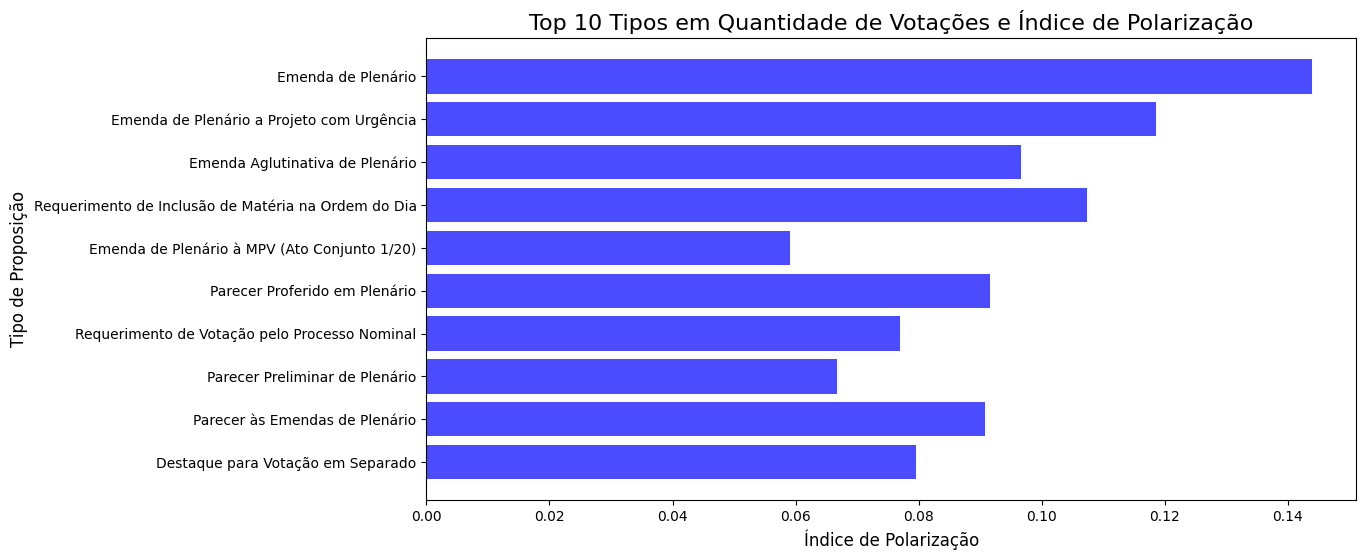

In [33]:
# Agrupar os dados por tipo para calcular o índice de polarização e a quantidade de votações
indice_polarizacao_tipo = analise_votacao.groupby('tipo').apply(calcular_indice_polarizacao)
quantidade_votacoes_tipo = analise_votacao.groupby('tipo').size()

# Criar um DataFrame com o índice de polarização e a quantidade de votações
polarizacao_por_tipo = pd.DataFrame({
    'Tipo': indice_polarizacao_tipo.index,
    'Índice de Polarização': indice_polarizacao_tipo.values,
    'Quantidade de Votações': quantidade_votacoes_tipo.values
}).dropna()

# Selecionar os Top 10 tipos com maior quantidade de votações
top_10_tipos = polarizacao_por_tipo.nlargest(10, 'Quantidade de Votações')

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.barh(top_10_tipos['Tipo'], top_10_tipos['Índice de Polarização'], color='blue', alpha=0.7)

# Título e rótulos dos eixos
plt.title('Top 10 Tipos em Quantidade de Votações e Índice de Polarização', fontsize=16)
plt.xlabel('Índice de Polarização', fontsize=12)
plt.ylabel('Tipo de Proposição', fontsize=12)

# Exibir o gráfico
plt.gca().invert_yaxis()  # Inverter o eixo Y para que o Top 1 fique no topo
plt.show()

In [34]:
# Função para plotar o gráfico e a tabela com base no ano selecionado
def plot_polarizacao_e_tabela_por_ano(ano):
    # Filtrar os dados para o ano selecionado
    dados_ano = analise_votacao[analise_votacao['ano_votacao'] == ano]

    # Calcular o índice de polarização por tema para o ano selecionado
    indice_polarizacao_ano = dados_ano.groupby('tema').apply(calcular_indice_polarizacao)
    quantidade_votacoes_ano = dados_ano.groupby('tema').size()

    # Criar um DataFrame com o índice de polarização e quantidade de votações
    polarizacao_ponderada_ano = pd.DataFrame({
        'Tema': indice_polarizacao_ano.index,
        'Índice de Polarização': indice_polarizacao_ano.values,
        'Quantidade de Votações': quantidade_votacoes_ano.values
    }).dropna()

    # Ajustando os índices para casar com os números do gráfico
    polarizacao_ponderada_ano.index = range(1, len(polarizacao_ponderada_ano) + 1)

    # Plotar o gráfico com pontos numerados para cada tema
    plt.figure(figsize=(12, 6))
    point_size = 200  # Tamanho fixo dos pontos

    for i, (tema, row) in enumerate(polarizacao_ponderada_ano.iterrows(), start=1):
        plt.scatter(row['Quantidade de Votações'], row['Índice de Polarização'], s=point_size, alpha=0.7, c='b', edgecolors='w')
        plt.text(row['Quantidade de Votações'], row['Índice de Polarização'], str(i), fontsize=9, ha='center', va='center', color='white')

    # Título e rótulos dos eixos
    plt.title(f'Índice de Polarização por Tema - Ano {ano}', fontsize=16)
    plt.xlabel('Quantidade de Votações', fontsize=12)
    plt.ylabel('Índice de Polarização', fontsize=12)

    # Adicionando grade
    plt.grid(True, linestyle='--', alpha=0.5)

    # Ajuste do layout sem a legenda
    plt.tight_layout()
    plt.show()

    # Exibir a tabela dinâmica com o índice de polarização e a quantidade de votações
    display(polarizacao_ponderada_ano.style.set_caption(f"Tabela de Índice de Polarização por Tema - Ano {ano}").set_table_styles(
        [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
    ))

# Criar uma barra deslizante para o ano
anos = sorted(analise_votacao['ano_votacao'].dropna().unique())
ano_slider = widgets.IntSlider(value=anos[0], min=anos[0], max=anos[-1], step=1, description='Ano')

# Conectar a barra deslizante à função de plotagem e exibição da tabela
widgets.interact(plot_polarizacao_e_tabela_por_ano, ano=ano_slider)


interactive(children=(IntSlider(value=2003, description='Ano', max=2023, min=2003), Output()), _dom_classes=('…

<function __main__.plot_polarizacao_e_tabela_por_ano(ano)>

In [35]:
# Função para plotar o gráfico e a tabela com base no ano selecionado (agora por "Tipo")
def plot_polarizacao_e_tabela_por_tipo(ano):
    # Filtrar os dados para o ano selecionado
    dados_ano = analise_votacao[analise_votacao['ano_votacao'] == ano]

    # Calcular o índice de polarização por tipo para o ano selecionado
    indice_polarizacao_ano = dados_ano.groupby('tipo').apply(calcular_indice_polarizacao)
    quantidade_votacoes_ano = dados_ano.groupby('tipo').size()

    # Criar um DataFrame com o índice de polarização e quantidade de votações por tipo
    polarizacao_ponderada_ano = pd.DataFrame({
        'Tipo': indice_polarizacao_ano.index,
        'Índice de Polarização': indice_polarizacao_ano.values,
        'Quantidade de Votações': quantidade_votacoes_ano.values
    }).dropna()

    # Ajustando os índices para casar com os números do gráfico
    polarizacao_ponderada_ano.index = range(1, len(polarizacao_ponderada_ano) + 1)

    # Plotar o gráfico com pontos numerados para cada tipo
    plt.figure(figsize=(12, 6))
    point_size = 200  # Tamanho fixo dos pontos

    for i, (tipo, row) in enumerate(polarizacao_ponderada_ano.iterrows(), start=1):
        plt.scatter(row['Quantidade de Votações'], row['Índice de Polarização'], s=point_size, alpha=0.7, c='b', edgecolors='w')
        plt.text(row['Quantidade de Votações'], row['Índice de Polarização'], str(i), fontsize=9, ha='center', va='center', color='white')

    # Título e rótulos dos eixos
    plt.title(f'Índice de Polarização por Tipo - Ano {ano}', fontsize=16)
    plt.xlabel('Quantidade de Votações', fontsize=12)
    plt.ylabel('Índice de Polarização', fontsize=12)

    # Adicionando grade
    plt.grid(True, linestyle='--', alpha=0.5)

    # Ajuste do layout sem a legenda
    plt.tight_layout()
    plt.show()

    # Exibir a tabela dinâmica com o índice de polarização e a quantidade de votações
    display(polarizacao_ponderada_ano.style.set_caption(f"Tabela de Índice de Polarização por Tipo - Ano {ano}").set_table_styles(
        [{'selector': 'caption', 'props': [('font-size', '16px'), ('text-align', 'center')]}]
    ))

# Criar uma barra deslizante para o ano
anos = sorted(analise_votacao['ano_votacao'].dropna().unique())
ano_slider = widgets.IntSlider(value=anos[0], min=anos[0], max=anos[-1], step=1, description='Ano')

# Conectar a barra deslizante à função de plotagem e exibição da tabela
widgets.interact(plot_polarizacao_e_tabela_por_tipo, ano=ano_slider)

interactive(children=(IntSlider(value=2003, description='Ano', max=2023, min=2003), Output()), _dom_classes=('…

<function __main__.plot_polarizacao_e_tabela_por_tipo(ano)>

In [36]:
# Função para plotar o gráfico com os Top 10 tipos por quantidade de votações no ano selecionado
def plot_top_10_tipos_por_ano(ano):
    # Filtrar os dados para o ano selecionado
    dados_ano = analise_votacao[analise_votacao['ano_votacao'] == ano]

    # Calcular o índice de polarização e quantidade de votações por tipo no ano selecionado
    indice_polarizacao_tipo = dados_ano.groupby('tipo').apply(calcular_indice_polarizacao)
    quantidade_votacoes_tipo = dados_ano.groupby('tipo').size()

    # Criar um DataFrame com o índice de polarização e a quantidade de votações
    polarizacao_por_tipo = pd.DataFrame({
        'Tipo': indice_polarizacao_tipo.index,
        'Índice de Polarização': indice_polarizacao_tipo.values,
        'Quantidade de Votações': quantidade_votacoes_tipo.values
    }).dropna()

    # Selecionar os Top 10 tipos com maior quantidade de votações
    top_10_tipos = polarizacao_por_tipo.nlargest(10, 'Quantidade de Votações')

    # Plotar o gráfico
    plt.figure(figsize=(12, 6))
    plt.barh(top_10_tipos['Tipo'], top_10_tipos['Índice de Polarização'], color='blue', alpha=0.7)

    # Título e rótulos dos eixos
    plt.title(f'Top 10 Tipos em Quantidade de Votações e Índice de Polarização - Ano {ano}', fontsize=16)
    plt.xlabel('Índice de Polarização', fontsize=12)
    plt.ylabel('Tipo de Proposição', fontsize=12)

    # Inverter o eixo Y para que o Top 1 fique no topo
    plt.gca().invert_yaxis()

    # Exibir o gráfico
    plt.show()

# Criar uma barra deslizante para o ano
anos = sorted(analise_votacao['ano_votacao'].dropna().unique())
ano_slider = widgets.IntSlider(value=anos[0], min=anos[0], max=anos[-1], step=1, description='Ano')

# Conectar a barra deslizante à função de plotagem
widgets.interact(plot_top_10_tipos_por_ano, ano=ano_slider)


interactive(children=(IntSlider(value=2003, description='Ano', max=2023, min=2003), Output()), _dom_classes=('…

<function __main__.plot_top_10_tipos_por_ano(ano)>

In [37]:
# Filtrar as votações polarizadas (onde percentual de votos "sim" <= 30% ou >= 70%)
votacoes_polarizadas = analise_votacao[(analise_votacao['percentual_voto_sim'] >= 0.4) & 
                                       (analise_votacao['percentual_voto_sim'] <= 0.6)]

# Exportar para CSV
votacoes_polarizadas.to_csv('../data/votacoes_polarizadas.csv', index=False)

# Exibir mensagem de sucesso
print("Arquivo 'votacoes_polarizadas.csv' exportado com sucesso!")

Arquivo 'votacoes_polarizadas.csv' exportado com sucesso!
